## 가설 : 달마다 많이 검색한 관광 유형과 관련된 관광지가 특화되어 있는 지역에 방문객이 많다.

## 데이터 불러오기

In [660]:
import pandas as pd
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import scipy
import scipy.stats as stats

client=pymongo.MongoClient("192.168.10.240",27017)
db= client['AI_LKJ']
collection_attraction = db['attraction_place_2023']
collection_concept = db['concept_2023']
collection_trend = db['trend_2023']
collection_trend_keyword = db['trend_keyword_2023']
collection_visitor=db['month_visitor_2023']
data_attraction = collection_attraction.find()
data_concept = collection_concept.find()
data_trend = collection_trend.find()
data_trend_keyword = collection_trend_keyword.find()
data_visitor = collection_visitor.find()
df_attraction = pd.DataFrame(data_attraction)
df_concept = pd.DataFrame(data_concept)
df_trend = pd.DataFrame(data_trend)
df_visitor = pd.DataFrame(data_visitor)
df_trend_keyword = pd.DataFrame(data_trend_keyword)
df_trend_keyword=df_trend_keyword.query("분류 !='기타'")
df_trend = df_trend.rename(columns={'여행유형/트렌드명': '여행유형'})
df_concept = df_concept.rename(columns={'목적지 유형': '목적지_유형'})
df_concept = df_concept.rename(columns={'목적지 검색량': '목적지_검색량'})

In [661]:
df_trend_keyword

,_id,순위,분류,관련 키워드,언급건수,지역구분
0,65dd3806bb908e26c802f1c1,1,휴식/힐링,힐링,104518,인천
1,65dd3806bb908e26c802f1c2,2,휴식/힐링,나들이,46381,인천
2,65dd3806bb908e26c802f1c3,3,레포츠,캠핑,43371,인천
4,65dd3806bb908e26c802f1c5,5,레포츠,등산,30371,인천
6,65dd3806bb908e26c802f1c7,7,레포츠,낚시,17505,인천
...,...,...,...,...,...,...
2110,65dd3806bb908e26c802f9ff,420,휴식/힐링,백캉스,1,강원
2111,65dd3806bb908e26c802fa00,420,레포츠,오프로드라이딩,1,강원
2112,65dd3806bb908e26c802fa01,420,체험,현지인체험,1,강원
2113,65dd3806bb908e26c802fa02,420,레포츠,bsac,1,강원


In [662]:
df_trend

,_id,기준연월,여행유형,언급건수,지역구분
0,65d86664bb908e26c802a800,202310,휴식/힐링,25282,인천
1,65d86664bb908e26c802a801,202308,휴식/힐링,23383,인천
2,65d86664bb908e26c802a802,202306,휴식/힐링,22363,인천
3,65d86664bb908e26c802a803,202309,휴식/힐링,21743,인천
4,65d86664bb908e26c802a804,202305,휴식/힐링,21319,인천
...,...,...,...,...,...
295,65d86664bb908e26c802a927,202310,미식,2699,강원
296,65d86664bb908e26c802a928,202304,미식,2699,강원
297,65d86664bb908e26c802a929,202311,미식,2614,강원
298,65d86664bb908e26c802a92a,202302,체험,2555,강원


In [663]:
df_trend['여행유형'].unique()

array(['휴식/힐링', '레포츠', '기타', '미식', '체험'], dtype=object)

In [664]:
df_concept['목적지_유형'].unique()

array(['전체', '숙박', '음식', '기타관광', '쇼핑', '자연관광', '문화관광', '역사관광', '체험관광',
       '레저스포츠'], dtype=object)

## 데이터 전처리

### attraction 분류

In [665]:
df_attraction['분류'].unique()

array(['교통시설', '쇼핑몰', '백화점', '시장', '자연경관(하천/해양)', '호텔', '도시공원', '전시시설',
       '육상레저스포츠', '종교성지', '콘도미니엄', '레저스포츠시설', '대형마트', '웰니스관광', '공연시설',
       '랜드마크관광', '기타문화관광지', '기타레저스포츠', '자연경관(산)', '테마공원', '기타관광',
       '복합관광시설', '수상레저스포츠', '역사유적지', '데이트코스', '자연공원', '면세점', '자연생태',
       '자연관광(산)', '농/산/어촌체험', '카페/찻집', '음식점기타', '외국식', '간이음식', '전문음식',
       '한식'], dtype=object)

In [666]:
df_attraction= df_attraction.drop(df_attraction.query("분류 =='교통시설'").index)

In [667]:
df_attraction.loc[df_attraction.query("분류 in ['카페/찻집', '간이음식', '한식', '전문음식', '외국식','음식점기타']").index,'목적지_유형'] = '음식'
# ['카페/찻집', '간이음식', '한식', '전문음식', '외국식', '음식점기타']

In [668]:
df_attraction.loc[df_attraction.query("분류 == ['도시공원', '자연경관(하천/해양)','자연경관(산)','자연관광(산)', '자연생태','데이트코스', '자연공원','랜드마크관광']").index,'목적지_유형']='자연관광'

In [669]:
df_attraction.loc[df_attraction.query("분류 == ['쇼핑몰', '백화점', '대형마트','면세점']").index,'목적지_유형']='쇼핑'

In [670]:
df_attraction.loc[df_attraction.query("분류 == ['시장', '전시시설', '공연시설', '기타문화관광지', '테마공원','웰니스관광','농/산/어촌체험','역사유적지','종교성지']").index,'목적지_유형']='문화관광'

In [671]:
df_attraction.loc[df_attraction.query("분류 == ['육상레저스포츠','레저스포츠시설','캠핑','수상레저스포츠', '기타레저스포츠']").index,'목적지_유형']='레저스포츠'

In [672]:
df_attraction.loc[df_attraction.query("분류 == ['콘도미니엄', '호텔', '기타숙박']").index,'목적지_유형']='숙박'

In [673]:
df_attraction['목적지_유형'].unique()

array(['쇼핑', '문화관광', '자연관광', '숙박', '레저스포츠', nan, '음식'], dtype=object)

In [709]:
df_attraction.loc[df_attraction.loc[df_attraction['분류']=='복합관광시설'].index,"목적지_유형"] = '문화관광'

In [718]:
df_attraction.loc[df_attraction['분류']=='복합관광시설']

,_id,순위,관광지명,주소,분류,외지인 검색 수,지역구분,목적지_유형
90,65dec2ebbb908e26c803483b,91,파라다이스시티원더박스,인천 중구 영종해안남로321번길 186-0,복합관광시설,24283,인천,문화관광
168,65dec2ebbb908e26c8034889,69,아난티코브,부산 기장군 기장해안로 268-32,복합관광시설,33402,부산,숙박
336,65dec2ebbb908e26c8034931,37,제주신화월드,제주 서귀포시 신화역사로304번길 139-0,복합관광시설,30008,제주,문화관광
365,65dec2ebbb908e26c803494e,66,산굼부리,제주 제주시,복합관광시설,19850,제주,자연관광
407,65dec2ebbb908e26c8034978,8,휘닉스평창,강원 평창군 태기로 174-0,복합관광시설,146744,강원,문화관광
442,65dec2ebbb908e26c803499b,43,강원랜드,강원 정선군 하이원길 265-0,복합관광시설,73490,강원,문화관광
447,65dec2ebbb908e26c80349a0,48,고석정국민관광지,강원 철원군 창동로 2386-0,복합관광시설,65429,강원,문화관광
463,65dec2ebbb908e26c80349b0,64,하슬라아트월드,강원 강릉시 율곡로 1441-0,복합관광시설,50102,강원,문화관광
469,65dec2ebbb908e26c80349b6,70,정동진,강원 강릉시 정동역길 17-0,복합관광시설,47568,강원,자연관광


In [719]:
df_attraction.loc[[92,151,305,317,323,324,331,411,449,451,469,365],'목적지_유형']= '자연관광'

In [720]:
df_attraction.loc[[88, 140,193,172,315,351,428,435,445],'목적지_유형']= '문화관광'

In [721]:
df_attraction.loc[[189, ],'목적지_유형']= '음식'

In [722]:
df_attraction.loc[[168, ],'목적지_유형']= '숙박'

In [723]:
df_attraction['목적지_유형'].unique()

array(['쇼핑', '문화관광', '자연관광', '숙박', '레저스포츠', '음식'], dtype=object)

In [724]:
conditiona = "지역구분 =='강원'"
conditionb = "목적지_유형 =='문화관광'"
conditions = f"{conditiona} and {conditionb}"
df_attraction.query(conditions)

,_id,순위,관광지명,주소,분류,외지인 검색 수,지역구분,목적지_유형
400,65dec2ebbb908e26c8034971,1,속초관광수산시장,강원 속초시 중앙로147번길 16-0,시장,751688,강원,문화관광
403,65dec2ebbb908e26c8034974,4,강원랜드카지노,강원 정선군 하이원길 265-0,기타문화관광지,186869,강원,문화관광
404,65dec2ebbb908e26c8034975,5,강릉중앙시장,강원 강릉시 금성로 21-0,시장,166226,강원,문화관광
405,65dec2ebbb908e26c8034976,6,낙산사,강원 양양군 낙산사로 100-0,종교성지,149315,강원,문화관광
407,65dec2ebbb908e26c8034978,8,휘닉스평창,강원 평창군 태기로 174-0,복합관광시설,146744,강원,문화관광
409,65dec2ebbb908e26c803497a,10,비발디파크 오션월드,강원 홍천군 한치골길 262-0,테마공원,139851,강원,문화관광
414,65dec2ebbb908e26c803497f,15,주문진수산시장,강원 강릉시 시장1길 4-1,시장,126916,강원,문화관광
423,65dec2ebbb908e26c8034988,24,레고랜드코리아리조트,강원 춘천시 하중도길 125-0,테마공원,98265,강원,문화관광
424,65dec2ebbb908e26c8034989,25,경포대,강원 강릉시 경포로 365-0,역사유적지,96570,강원,문화관광
428,65dec2ebbb908e26c803498d,29,속초아이대관람차,강원 속초시 청호해안길 2-0,기타관광,89549,강원,문화관광


In [737]:
list_data = []
for x in list(df_attraction['지역구분'].unique()):
    for y in list(df_attraction['목적지_유형'].unique()):
        data_dict = {}
        data_dict['지역구분']=x
        data_dict['목적지_유형']=y
        data_dict['외지인 검색 수']=df_attraction.loc[(df_attraction['지역구분']==x) & (df_attraction['목적지_유형']==y),'외지인 검색 수'].sum()
        list_data.append(data_dict)
data_attraction_sum = pd.DataFrame(data=list_data)
data_attraction_sum

,지역구분,목적지_유형,외지인 검색 수
0,인천,쇼핑,1581325
1,인천,문화관광,1744408
2,인천,자연관광,1689039
3,인천,숙박,795159
4,인천,레저스포츠,598081
5,인천,음식,4052458
6,부산,쇼핑,2529353
7,부산,문화관광,1702520
8,부산,자연관광,1292879
9,부산,숙박,822314


### concept 분류

In [738]:
df_concept

,_id,기준연월,목적지_유형,목적지_검색량,지역구분
12,65dd913cbb908e26c80341ab,202303,숙박,190207,인천
13,65dd913cbb908e26c80341ac,202303,음식,942682,인천
15,65dd913cbb908e26c80341ae,202303,쇼핑,359873,인천
16,65dd913cbb908e26c80341af,202303,자연관광,189499,인천
17,65dd913cbb908e26c80341b0,202303,문화관광,237606,인천
...,...,...,...,...,...
595,65dd913cbb908e26c80343f2,202312,문화관광,230390,강원
596,65dd913cbb908e26c80343f3,202312,문화관광,56014,강원
597,65dd913cbb908e26c80343f4,202312,자연관광,217036,강원
598,65dd913cbb908e26c80343f5,202312,문화관광,16478,강원


In [739]:
df_concept['목적지_유형'].unique()

array(['숙박', '음식', '쇼핑', '자연관광', '문화관광', '레저스포츠'], dtype=object)

In [740]:
df_concept=df_concept.query("목적지_유형 != ['전체','기타관광']")
df_concept['목적지_유형'].unique()

array(['숙박', '음식', '쇼핑', '자연관광', '문화관광', '레저스포츠'], dtype=object)

In [741]:
df_concept.loc[df_concept.query("목적지_유형 == ['체험관광','역사관광']").index,'목적지_유형']='문화관광'

In [742]:
list_data = []
for x in list(df_concept['기준연월'].unique()):
    for y in list(df_concept['목적지_유형'].unique()):
        data_dict = {}
        data_dict['기준년월']=x
        data_dict['목적지_유형']=y
        data_dict['목적지_검색량']=df_concept.loc[(df_concept['기준연월']==x) & (df_concept['목적지_유형']==y),'목적지_검색량'].sum()
        list_data.append(data_dict)
data_concept_sum = pd.DataFrame(data=list_data)
data_concept_sum

,기준년월,목적지_유형,목적지_검색량
0,202303,숙박,1610566
1,202303,음식,5063675
2,202303,쇼핑,2227940
3,202303,자연관광,733461
4,202303,문화관광,2037415
...,...,...,...
67,202312,음식,5842078
68,202312,쇼핑,2625588
69,202312,자연관광,600543
70,202312,문화관광,2063092


### visitor 분류

In [743]:
df_visitor

,_id,기준년월,방문자_수,지역구분
0,65dd76f9bb908e26c8034161,202301,14321833,인천
1,65dd76f9bb908e26c8034162,202302,13187354,인천
2,65dd76f9bb908e26c8034163,202303,15620369,인천
3,65dd76f9bb908e26c8034164,202304,13830096,인천
4,65dd76f9bb908e26c8034165,202305,15906026,인천
5,65dd76f9bb908e26c8034166,202306,14338822,인천
6,65dd76f9bb908e26c8034167,202307,15492589,인천
7,65dd76f9bb908e26c8034168,202308,15449316,인천
8,65dd76f9bb908e26c8034169,202309,16422889,인천
9,65dd76f9bb908e26c803416a,202310,16131144,인천


In [744]:
list_data = []
for x in list(df_visitor['지역구분'].unique()):
    for y in list(df_visitor['기준년월'].unique()):
        data_dict = {}
        data_dict['지역구분']=x
        data_dict['기준년월']=y
        data_dict['방문자_수']=df_visitor.loc[(df_visitor['지역구분']==x) & (df_visitor['기준년월']==y),'방문자_수'].sum()
        list_data.append(data_dict)
data_visitor_sum = pd.DataFrame(data=list_data)
data_visitor_sum

,지역구분,기준년월,방문자_수
0,인천,202301,14321833
1,인천,202302,13187354
2,인천,202303,15620369
3,인천,202304,13830096
4,인천,202305,15906026
5,인천,202306,14338822
6,인천,202307,15492589
7,인천,202308,15449316
8,인천,202309,16422889
9,인천,202310,16131144


## DDA & EDA

### 지역별 방문자 수가 많은 관광지 유형
* 서울 : 쇼핑, 음식, 문화관광
* 부산 : 음심, 쇼핑, 문화관광
* 인천 : 음식, 문화관광, 자연관광
* 강원 : 음식, 문화관광, 숙박
* 제주 : 음식, 자연관광, 문화관광

In [751]:
pivot_attraction=pd.pivot_table(data=df_attraction,index="지역구분",columns = "목적지_유형",values='외지인 검색 수',aggfunc='sum')
pivot_attraction.loc['제주'].sort_values(ascending=False)[:3]

목적지_유형
음식      2615488.0
자연관광    1323187.0
문화관광     999317.0
Name: 제주, dtype: float64

<Axes: xlabel='목적지_유형', ylabel='외지인 검색 수'>

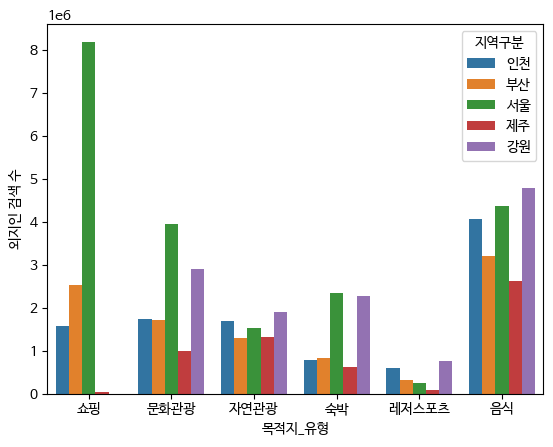

In [770]:
sns.barplot(data=data_attraction_sum, x= "목적지_유형", y= "외지인 검색 수",hue="지역구분",errorbar=None)

### 목적지 유형별 검색량이 많은 월
* 숙박 : 8월, 7월, 12월
* 음식 : 8월, 7월, 12월
* 문화관광 : 10월, 8월, 9월
* 쇼핑 : 12월, 9월, 10월
* 자연관광 : 10월, 9월, 8월
* 레저스포츠 : 10월, 8월, 9월


In [521]:
pivot_concept=pd.pivot_table(data=df_concept,index="목적지_유형",columns = "기준연월",values='목적지_검색량',aggfunc='sum')
pivot_concept.loc['숙박',:].sort_values(ascending=False)[:3]

기준연월
202308    2573834
202307    2278415
202312    2128577
Name: 숙박, dtype: int64

In [522]:
pivot_concept.loc['음식',:].sort_values(ascending=False)[:3]

기준연월
202308    6641833
202307    6107752
202312    5842078
Name: 음식, dtype: int64

In [654]:
pivot_concept.loc['문화관광',:].sort_values(ascending=False)[:5]

기준연월
202310    2825296
202308    2519828
202309    2436732
202305    2318110
202306    2243152
Name: 문화관광, dtype: int64

In [659]:
pivot_concept.loc['쇼핑',:].sort_values(ascending=False)[:3]

기준연월
202312    2625588
202309    2411906
202310    2408879
Name: 쇼핑, dtype: int64

In [658]:
pivot_concept.loc['자연관광',:].sort_values(ascending=False)[:3]

기준연월
202310    1004736
202309     947937
202308     888573
Name: 자연관광, dtype: int64

In [526]:
pivot_concept.loc['레저스포츠',:].sort_values(ascending=False)[:3]

기준연월
202310    619549
202308    566495
202309    555517
Name: 레저스포츠, dtype: int64

In [762]:
data_concept_sum

,기준년월,목적지_유형,목적지_검색량
0,202303,숙박,1610566
1,202303,음식,5063675
2,202303,쇼핑,2227940
3,202303,자연관광,733461
4,202303,문화관광,2037415
...,...,...,...
67,202312,음식,5842078
68,202312,쇼핑,2625588
69,202312,자연관광,600543
70,202312,문화관광,2063092


<Axes: xlabel='기준년월', ylabel='목적지_검색량'>

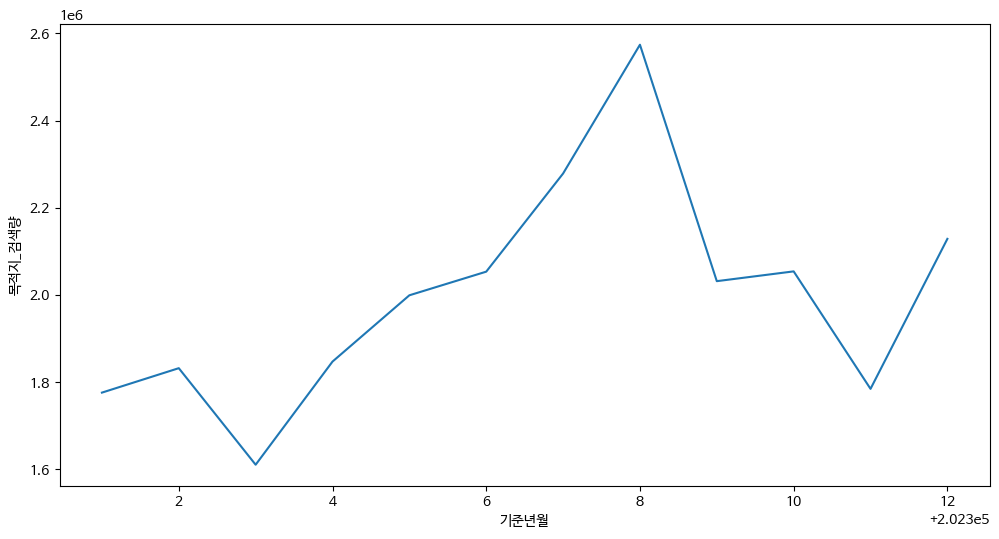

In [767]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_concept_sum.query("목적지_유형 =='숙박'"), x= "기준년월", y= "목적지_검색량",errorbar=None)

### 지역별 방문자 수가 많은 월
* 서울 : 3월, 12월, 9월
* 부산 : 9월, 8월, 1월
* 인천 : 9월, 10월, 5월
* 강원 : 8월, 7월, 10월
* 제주 : 8월, 10월, 1월

In [528]:
pivot_visitor=pd.pivot_table(data=df_visitor,index="지역구분",columns = "기준년월",values='방문자_수',aggfunc='sum')
pivot_visitor.loc['제주'].sort_values(ascending=False)

기준년월
202308    5982112
202310    5614039
202301    5377591
202307    5336175
202303    5274889
202305    5208883
202304    5123197
202306    5059521
202302    4935915
202309    4788081
202311    4672499
202312    4638646
Name: 제주, dtype: int64

<Axes: xlabel='기준년월', ylabel='방문자_수'>

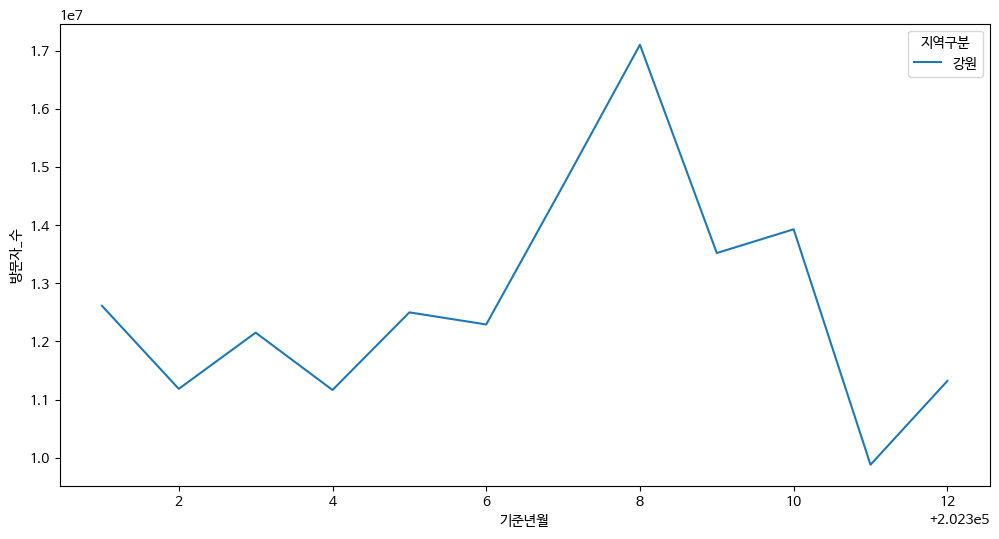

In [769]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_visitor_sum.query("지역구분 == '강원'"), x= "기준년월",y='방문자_수',hue="지역구분",errorbar=None)

## CDA

### 지역별 정규분포 확인
* 서울 : 정규분포
  * p-value = 0.9973136453905183
* 부산 : 정규분포
  * p-value = 0.28461342141298596
* 강원 : 정규분포
  * p-value = 0.4760507773414123
* 제주 : 정규분포
  * p-value = 0.8092344673462573
* 인천 : 정규분포
  * p-value = 0.32901922814749984

In [530]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'])

ShapiroResult(statistic=0.9856587827031315, pvalue=0.9973136453905183)

In [531]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'])

ShapiroResult(statistic=0.9198427916245954, pvalue=0.28461342141298596)

In [532]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'])

ShapiroResult(statistic=0.9382747644577106, pvalue=0.4760507773414123)

In [533]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'])

ShapiroResult(statistic=0.9618033569729677, pvalue=0.8092344673462573)

In [534]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'])

ShapiroResult(statistic=0.9248841521619882, pvalue=0.32901922814749984)

### 목적지 유형별 정규분포 확인
* 숙박
  * p-value = 0.5630228165598207
* 음식
  * p-value = 0.40407951762031513
* 문화관광
  * p-value = 0.5360945988411083
* 쇼핑
  * p-value = 0.6220566078088251
* 자연관광
  * p-value = 0.4756991427233535
* 레저스포츠
  * p-value = 0.535901696770146

In [541]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'])

ShapiroResult(statistic=0.9448284940057353, pvalue=0.5630228165598207)

In [537]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'])

ShapiroResult(statistic=0.9322057563272238, pvalue=0.40407951762031513)

In [538]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'])

ShapiroResult(statistic=0.9428679178405824, pvalue=0.5360945988411083)

In [535]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'])

ShapiroResult(statistic=0.9489753996289559, pvalue=0.6220566078088251)

In [539]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_concept_sum.query("목적지_유형 =='자연관광'").sort_values(by='기준년월')['목적지_검색량'])

ShapiroResult(statistic=0.9382467843259368, pvalue=0.4756991427233535)

In [540]:
# pvalue > 0.05 : 정규분포
stats.shapiro(data_concept_sum.query("목적지_유형 =='레저스포츠'").sort_values(by='기준년월')['목적지_검색량'])

ShapiroResult(statistic=0.9428536799448659, pvalue=0.535901696770146)

### 숙박 : 강원

#### 서울
* p-value = 0.990483508118553
*  상관관계가 없음
#### 부산
* p-value = 0.28971251599469205
*  상관관계가 없음
#### 강원
* p-value = 0.0021862858292930726
*  상관관계가 있음
#### 제주
* p-value = 0.12725139344805295
*  상관관계가 없음
#### 인천
* p-value = 0.2262992602331968
*  상관관계가 없음

In [587]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.003867096029181304, pvalue=0.990483508118553)

In [588]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.3333197273833854, pvalue=0.28971251599469205)

In [589]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.790967224131266, pvalue=0.0021862858292930726)

In [590]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.4654911218026511, pvalue=0.12725139344805295)

In [591]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.37755229725621253, pvalue=0.2262992602331968)

### 음식 : 강원

#### 서울
* p-value = 0.6538630450177505
*  상관관계가 없음
#### 부산
* p-value = 0.13908554832836928
*  상관관계가 없음
#### 강원
* p-value = 0.001188649252708536
*  상관관계가 있음
#### 제주
* p-value = 0.09443155788276819
*  상관관계가 없음
#### 인천
* p-value = 0.11447584953446001
*  상관관계가 없음

In [592]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.14460941681289413, pvalue=0.6538630450177505)

In [593]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.45308623215309946, pvalue=0.13908554832836928)

In [594]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.8166553949908238, pvalue=0.001188649252708536)

In [595]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5044487274015599, pvalue=0.09443155788276819)

In [596]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.4797605377648344, pvalue=0.11447584953446001)

### 문화관광 : 강원, 인천

#### 서울
* p-value = 0.4869825100231865
*  상관관계가 없음
#### 부산
* p-value = 0.31289112490561144
*  상관관계가 없음
#### 강원
* p-value = 0.02512906049753106
*  상관관계가 있음
#### 제주
* p-value = 0.09308079685774018
*  상관관계가 없음
#### 인천
* p-value = 0.021900068051055294
*  상관관계가 있음

In [614]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.22251470278419502, pvalue=0.4869825100231865)

In [615]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.31855904570044996, pvalue=0.31289112490561144)

In [616]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.6395436419386263, pvalue=0.02512906049753106)

In [617]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5062340428673195, pvalue=0.09308079685774018)

In [618]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.650842287680369, pvalue=0.021900068051055294)

### 쇼핑 : 인천, 부산, 서울 

#### 서울
* p-value = 0.04940056388619214
*  상관관계가 있음
#### 부산
* p-value = 0.04436822894483745
*  상관관계가 있음
#### 강원
* p-value = 0.5215515020883321
*  상관관계가 없음
#### 제주
* p-value = 0.6998069001225202
*  상관관계가 없음
#### 인천
* p-value = 0.01604408597695678
*  상관관계가 있음

In [603]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5772096944063122, pvalue=0.04940056388619214)

In [604]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5879459790968465, pvalue=0.04436822894483745)

In [605]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.20556802953517708, pvalue=0.5215515020883321)

In [606]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=-0.12452197007116611, pvalue=0.6998069001225202)

In [607]:
# pvalue < 0.05 : 상관관계가 있음
stats.pearsonr(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.674904599685121, pvalue=0.01604408597695678)

### 자연관광

#### 서울
* p-value = 0.14298624815250666
*  상관관계가 없음
#### 부산
* p-value = 0.06303861881995301
*  상관관계가 없음
#### 강원
* p-value = 0.07868976116963107
*  상관관계가 없음
#### 제주
* p-value = 0.2528639854241719
*  상관관계가 없음
#### 인천
* p-value = 0.1140732113999062
*  상관관계가 없음

In [619]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='자연관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.44914790545543465, pvalue=0.14298624815250666)

In [620]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='자연관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5515310934166969, pvalue=0.06303861881995301)

In [621]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='자연관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5264430840344718, pvalue=0.07868976116963107)

In [622]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='자연관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.35823964047791723, pvalue=0.2528639854241719)

In [623]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='자연관광'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.4802269183484463, pvalue=0.1140732113999062)

### 레저스포츠

#### 서울
* p-value = 0.8168938172692074
*  상관관계가 없음
#### 부산
* p-value = 0.712666664211392
*  상관관계가 없음
#### 강원
* p-value = 0.05355735238738282
*  상관관계가 없음
#### 제주
* p-value = 0.14479330086392703
*  상관관계가 없음
#### 인천
* p-value = 0.10508733900841719
*  상관관계가 없음

In [624]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='레저스포츠'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.07496390711395372, pvalue=0.8168938172692074)

In [625]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='레저스포츠'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.11897470561474566, pvalue=0.712666664211392)

In [626]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='레저스포츠'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.5689078155657367, pvalue=0.05355735238738282)

In [627]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='제주'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='레저스포츠'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.44734687384862853, pvalue=0.14479330086392703)

In [628]:
# pvalue > 0.05 : 상관관계가 없음
stats.pearsonr(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'],data_concept_sum.query("목적지_유형 =='레저스포츠'").sort_values(by='기준년월')['목적지_검색량'])

PearsonRResult(statistic=0.49093185941249995, pvalue=0.10508733900841719)

### 상관계수 분석
* 숙박 - 강원 : 0.790967
* 음식 - 강원 : 	0.816655
* 문화관광 - 강원 : 0.639544
* 문화관광 - 인천 : 0.650842
* 쇼핑 - 인천 : 0.674905
* 쇼핑 - 부산 : 0.587946
* 쇼핑 - 서울 : 0.57721

In [644]:
# 숙박 - 강원
pd.DataFrame(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='숙박'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()# pvalue < 0.05 : 상관관계가 있음

,index,0
index,1.000000,0.790967
0,0.790967,1.000000


In [645]:
# 음식 - 강원
pd.DataFrame(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='음식'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()

,index,0
index,1.000000,0.816655
0,0.816655,1.000000


In [646]:
# 문화관광 - 강원
pd.DataFrame(data_visitor_sum.query("지역구분 =='강원'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()

,index,0
index,1.000000,0.639544
0,0.639544,1.000000


In [647]:
# 문화관광 - 인천
pd.DataFrame(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='문화관광'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()

,index,0
index,1.000000,0.650842
0,0.650842,1.000000


In [648]:
# 쇼핑 - 인천
pd.DataFrame(data_visitor_sum.query("지역구분 =='인천'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()

,index,0
index,1.000000,0.674905
0,0.674905,1.000000


In [650]:
# 쇼핑 - 부산
pd.DataFrame(data_visitor_sum.query("지역구분 =='부산'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()

,index,0
index,1.000000,0.587946
0,0.587946,1.000000


In [652]:
# 쇼핑 - 서울
pd.DataFrame(data_visitor_sum.query("지역구분 =='서울'").sort_values(by='기준년월')['방문자_수'].values,data_concept_sum.query("목적지_유형 =='쇼핑'").sort_values(by='기준년월')['목적지_검색량'].values).reset_index().corr()

,index,0
index,1.00000,0.57721
0,0.57721,1.00000


## 평가

### 분석 
* 목적지 유형 별 많이 방문한 월
  * 숙박 : 8, 7, 12
  * 음식 : 8, 7, 12
  * 문화관광 : 10, 8, 9
  * 쇼핑 : 12, 9, 10 
  * 자연관광 : 10, 9, 8
  * 레저스포츠 : 10, 8, 9
* 지역 별 많이 방문한 월 
  * 서울 : 3, 12, 9
  * 부산 : 9, 8, 1
  * 인천 : 9, 10, 5
  * 강원 : 8, 7, 10
  * 제주 : 8, 10, 1
* 검색량과 방문객 수의 상관관계가 있는 목적지 유형과 지역
  * 숙박 : 강원
  * 음식 : 강원
  * 문화관광 : 강원, 인천
  * 쇼핑 - 인천, 부산, 서울
  * 레저스포츠 : X
  * 자연관광 : X

### 결론
* 숙박과 음식관 관련된 관광지를 많이 방문한 8,7,12월에는 강원도를 여행지로 추천
* 문화관광과 관련된 관광지를 많이 방문한 10, 8, 9월에는 인천, 강원도를 여행지로 추천
* 쇼핑과 관련된 관광지를 많이 방문한 12, 9, 10월에는 인천, 서울, 부산을 여행지로 추천

### 한계
* 많이 방문한 월이 특정 달에만 집중되어 있는데, 이는 지역을 5개만 선택해서 그런것 같다.
* 채택이 되면 더 많은 지역을 바탕으로 데이터를 수집하여 더 세부적인 여행지 추천을 제공해주겠다. 